In [22]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *          

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [23]:
heat_df = pd.read_csv('data/utilities.csv', usecols = ['temp','ccf'])

heat_df = heat_df.loc[~(((heat_df['temp'] == 60) & (heat_df['ccf']==129)) | 
                        ((heat_df['temp'] == 41) & (heat_df['ccf']==16))), :]

# Cross-Validation

We can use the train-test paradigm to help us choose a model. The idea is to further divide the train set into separate parts where we fit the model on one part and evaluate it on another. This approach is called *cross-validation*.  We describe one version, called $k$*-fold cross-validation*. {numref}`Figure %s <CVDiagram>` shows the idea behind this division of the data.

```{figure} figures/CVDiagram.png
---
name: CVDiagram
---

Five-fold Cross-Validation. The train set is divide into 5 parts, which are used in turn to validate models built on the remainder of the data. 
```

Cross-validation can help select the general form of a model. By this we mean, the degree of the polynomial, the number of features in the model, or a cut-off for a regularization penalty (covered in the next section). The basic steps behind $k$-fold cross-validation go as follows. 

+ Divide the train set into $k$ parts of roughly the same size, each of these parts are called *folds*. Use the same technique that was used to create the train and test sets to make the folds. Typically, we divide the data at random.

+ Set one fold aside to act as a test set.
    + Fit all models on the remainder of the train data (the training data less the particular fold).
    + Use the fold you set aside to evaluate all of these models.
    
+ Repeat this process for a total of $k$ times, where each time you set aside one fold, use the rest of the train set to fit the models, and evaluate them on the fold that was set aside.

+ Combine the error in fitting each model across the folds, and choose the model with the smallest error. 

These fitted models will not have identical coefficients across folds. As an example, when we fit a polynomial of, say, degree 3, we average the MSE across the $k$ folds to get an average MSE for the $k$ fitted-polynomials of degree 3. We then compare the MSEs and choose the degree of the polynomial with the lowest MSE.  The actual coefficients for the $x$, $x^2$ and $x^3$ terms in the cubic polynomial are not the same in each of the $k$ fits. Once the polynomial degree is selected, we refit the model using all of the training data and evaluate it on the test set. (We haven't used the test set in any of the earlier steps to select the model).

Typically, we use 5 or 10 folds.  Another popular choice puts one observation in each fold. This special case is called *leave-one-out cross-validation*. It's popularity stems from the simplicity in adjusting a least squares fit to have one fewer observation. 

Generally, $k$-fold cross-validation takes some computation time since we typically have to refit each model from scratch for each fold. The `scikit-learn` library provides a convenient [`sklearn.model_selection.KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class to implement $k$-fold cross-validation. We provide an example of $k$-fold cross-validation to give an idea of how it works.

## Example: Fitting a Bent Line Model with Cross-validation

We demonstrate $k$-fold cross-validation on the gas consumption example. However, this time we fit a different type of model. The original scatter plot of the data looks like the points fall along two connected line segments. In cold temperatures the relationship between gas consumption and temperature looks roughly linear with a negative slope of about $-4$ cubic ft/degree, and in warmer months, the relationship appears nearly flat. So, rather than fit a polynomial, we can fit a bent line to the data. 

Let's start by fitting a line with a bend at 65 degrees. To do this, we create a feature that enables the points with temperatures above 65 to have a different slope. The model is

$$
y = \theta_0 + \theta_1x + \theta_2(x-65)^+
$$

Here, $ (~)^+ $ stands for "positive part" so when $ x $ is less than 65 it evaluates to 0, and when $ x $ is 65 or greater, it is just $ x-65 $. 

In [24]:
y = heat_df['ccf']
X = heat_df[['temp']]

X["temp65p"] = (X['temp'] - 65) * (X['temp'] >= 65 )
bend = LinearRegression().fit(X, y)

Let's overlay this fitted "curve" on the scatter plot to see how well it captures the shape of the data.

In [38]:
temp = np.arange(10, 80, 1)
temp65p = (temp - 65) * (temp >= 65)

Xs = pd.DataFrame({'temp': temp, 'temp65p':temp65p})
y_hats = bend.predict(Xs)

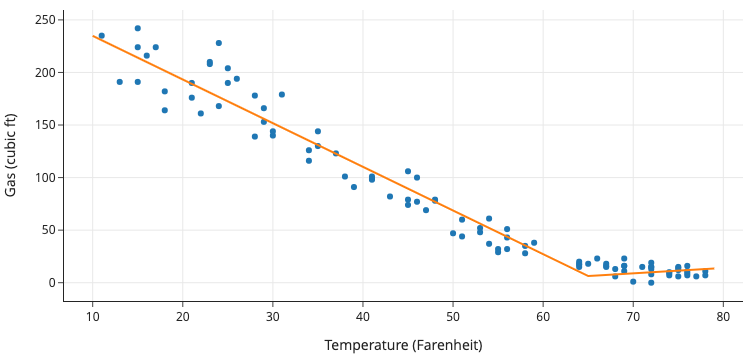

In [39]:
fig = px.scatter(heat_df, x='temp', y='ccf',
                 labels={'temp':'Temperature (Farenheit)',
                        'ccf':'Gas (cubic ft)'},
                width=350, height=250)

fig.add_trace(
    go.Scatter(x=Xs['temp'], y=y_hats))

fig.update_layout(showlegend=False)
fig.show()

This model appears to fit the data much better than a polynomial. But, there are many bent line models possible. The line might bend at 55 degrees or 60 degrees, and so on. We can use $k$-fold cross-validation to choose the temperature value at which the line bends. Let's consider models with bends at $ 40, 41, 42, \ldots, 68, 69 $ degrees. For each of these, we need to create the additional feature to enable the line to bend there. 

In [71]:
bends = np.arange(40, 70, 1)

for i in bends:
    heat_df[ 'temp'+ i.astype('str') + 'p'] = ((heat_df['temp'] - i)
                                               * (heat_df['temp'] >= i)) 

heat_df

,temp,ccf,temp40p,temp41p,...,temp66p,temp67p,temp68p,temp69p
0,29,166,0,0,...,0,0,0,0
1,31,179,0,0,...,0,0,0,0
2,15,224,0,0,...,0,0,0,0
...,...,...,...,...,...,...,...,...,...
96,76,11,36,35,...,10,9,8,7
97,55,32,15,14,...,0,0,0,0
98,39,91,0,0,...,0,0,0,0


The first step in cross-validation is to create our train and test sets. We choose 22 observations at random to be placed in the test set. That leaves 75 for the train set.

In [61]:
y = heat_df['ccf']
X = heat_df.drop(['ccf'], axis=1)

test_size = 22

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=0)

Now we can divide the train set into folds. We use three folds so that we have 25 observations in each fold. For each fold, we fit 30 models, one for each bend in the line. 

In [72]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=66)

validation_errors = np.zeros((3, 30))
i = 0

for train_idx, valid_idx in kf.split(X_train):
    
    split_X_train, split_X_valid = (X_train.iloc[train_idx, :],
                                    X_train.iloc[valid_idx, :])
    split_Y_train, split_Y_valid = (y_train.iloc[train_idx], 
                                    y_train.iloc[valid_idx])
    
    bent_models = [LinearRegression().fit(split_X_train.iloc[ :, [0,j]], 
                                          split_Y_train)
        for j in range(1,31)]
    
    bent_preds = [bent_models[j].predict(split_X_valid.iloc[ :, [0,(j+1)]])
         for j in range(30)]
    
    error_bend = [mean_squared_error(split_Y_valid, bent_preds[j])
         for j in range(30)]
    
    validation_errors[i][ : ] = error_bend
    i = i+1       

Then, we combine the validation errors across the 3-folds and plot them against the location of the bend.

In [63]:
totals = [ sum(x)/3 for x in validation_errors.transpose() ]

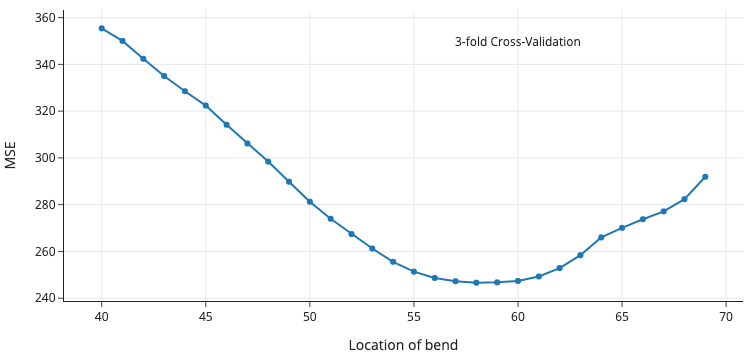

In [65]:
fig = px.line(x=bends, y=totals, markers=True,
             width=350, height=250)

fig.add_annotation(x=60, y=350,
            text="3-fold Cross-Validation", showarrow=False)

fig.update_layout(showlegend=False, 
                  xaxis_title='Location of bend',
                  yaxis_title='MSE')

fig.show()

The MSE looks quite flat for 57 to 60 degrees, but the minimum occurs at 58 so we choose that model. To assess this model on the test set, we first fit the bent line model at 58 degrees on the entire train set.

In [67]:
bent_final = LinearRegression().fit(X_train.loc[:, ["temp", "temp58p"]], 
                                    y_train)

Then we use the fitted model to predict gas consumption for the test set.

In [69]:
y_pred_test = bent_final.predict(X_test.loc[:, ["temp", "temp58p"]])

mean_squared_error(y_test, y_pred_test)

Let's overlay the bent-line fit on the scatter plot and examine the residuals to get an idea as to the quality of the fit.

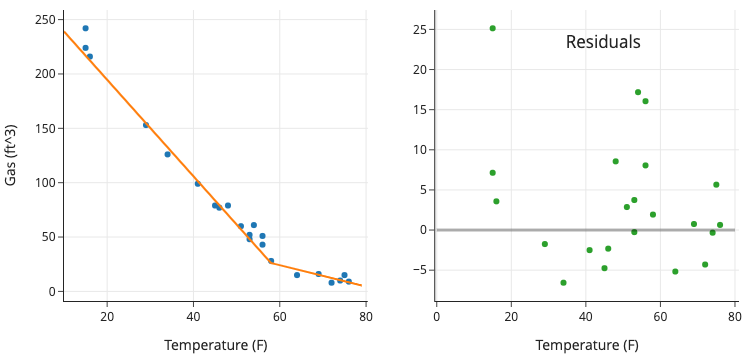

In [70]:
err58 = (y_test - y_pred_test)

temp = np.arange(10, 80, 1)
temp58p = (temp - 58) * (temp >= 58)

Xs = pd.DataFrame(data= np.transpose([temp,temp58p]), columns=['temp', 'temp58p'])
y_hats = bend_final.predict(Xs)


fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=X_test['temp'], y=y_test, mode='markers'),
    row=1, col=1)

fig.add_trace(
    go.Scatter(x=Xs['temp'], y=y_hats),
    row=1, col=1)
fig.update_xaxes(title='Temperature (F)', row=1, col=1)
fig.update_yaxes(title='Gas (ft^3)', row=1, col=1)


fig.add_trace(
    go.Scatter(x=X_test['temp'], y=err58,
              mode="markers"),
    row=1, col=2)

fig.add_shape(type="line",
    x0=0, y0=0, x1=80, y1=0,
    line=dict(
        color="Black", width=3),
    row=1, col=2)

fig.update_xaxes(title='Temperature (F)', row=1, col=2)

fig.update_layout(height=250, width=550, showlegend=False,
                 title={
        'text': "Residuals",
        'y':0.9,
        'x':0.85,
        'xanchor': 'right',
        'yanchor': 'top'})

fig.show()

The fitted curve looks reasonable, and the residuals are much smaller than those from the polynomial fit.   

Note that the `scikit-learn` library has a [`cross_val_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) method to automatically perform cross-validation, so we don't have to break the data into training and validation sets ourselves. 

Using cross-validation to manage model complexity has a couple critical limitations: typically it requires the complexity to vary discretely; and there may not be a natural way to order the models. 
Rather than changing the dimensions of a sequence of models, we can instead fit a large model and apply constraints on the size of the coefficients. This notion is called regularization and is the topic of the next section. 